In [1]:
%matplotlib inline

# Introduction

In remains to derive an optimal wavelength range where the correlation between flux and internal luminosity remains sufficiently strong. The motivation being to provide a suite of observing windows in wavelength space for class 0 and 1 protostellar objects, rather than a singular entry point.

# Import Dependencies

In [2]:
# System & OS
import warnings
warnings.filterwarnings('ignore')

# Data Analysis
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style('whitegrid')      # background
plt.rc('figure', titlesize=24)  # figure title 
plt.rc('axes', titlesize=18)    # axes title
plt.rc('axes', labelsize=18)    # xy labels
plt.rc('xtick', labelsize=14)   # x tick labels
plt.rc('ytick', labelsize=14)   # y tick labels
plt.rc('legend', fontsize=14)   # legend

# Mount Storage

`cd` to the `data/` directory.

In [3]:
%cd '../data/'

/Users/zach/Documents/Projects/Protostellar-Luminosity/data


# Feature Engineering

Read in our results from `2_linear_regression.ipynb`.

In [4]:
# Read in linear coefficients
coef = pd.read_csv('lin_coef.csv', skiprows=1, names=['Class', 
                                                      'Wavelength (microns)', 
                                                      'Slope', 
                                                      'Unc_slope', 
                                                      'Intercept', 
                                                      'Unc_intercept'])
# Read in correlation metrics
corr = pd.read_csv('corr_coef.csv', skiprows=1, names=['Class', 
                                                       'Wavelength (microns)', 
                                                       'Reduced chi-squared (linear space)', 
                                                       'Reduced chi-squared (log10 space)', 
                                                       'Correlation coefficient (linear space)', 
                                                       'Correlation coefficient (log10 space)'])
# Read in model variances
var = pd.read_csv('model_var.csv', skiprows=1, names=['Class', 
                                                      'Wavelength (microns)', 
                                                      'Std. Dev. of Model Variance'])
# Merge the dataframes along the class and wavelength columns
df = pd.merge(coef, corr, on=['Class', 'Wavelength (microns)'])
df = pd.merge(df, var, on=['Class', 'Wavelength (microns)'])
df

,Class,Wavelength (microns),Slope,Unc_slope,Intercept,Unc_intercept,Reduced chi-squared (linear space),Reduced chi-squared (log10 space),Correlation coefficient (linear space),Correlation coefficient (log10 space),Std. Dev. of Model Variance
0,0,36000.29516661664,0.205222,0.001546,-18.520233,0.002017,nan,-1.193127e+01,0.477976,0.748775,0.616077
1,1a,36000.29516661664,0.344443,0.000991,-18.817223,0.001138,nan,-1.848508e+01,0.343043,0.887259,0.297442
2,1b,36000.29516661664,0.594088,0.001722,-19.119119,0.001299,nan,-4.768334e+01,0.434630,0.886253,0.279484
3,All,36000.29516661664,0.457110,0.001066,-18.954541,0.001106,nan,-1.500133e+02,0.222630,0.836356,0.413830
4,0,24000.196777744422,0.218374,0.001342,-17.695543,0.001752,nan,-9.434475e+00,0.576396,0.810642,0.502709
...,...,...,...,...,...,...,...,...,...,...,...
399,All,0.050000409953634216,8.579801,0.078281,-47.486629,0.083609,nan,-1.986639e+05,0.068419,0.418470,1.343842
400,0,All,0.931400,0.005067,-11.827745,0.006656,nan,-1.984456e+06,0.504110,0.157855,4.299764
401,1a,All,0.982002,0.003401,-11.474304,0.003913,nan,-3.705078e+06,0.571380,0.158788,3.542970
402,1b,All,1.012902,0.003656,-11.380369,0.002766,nan,-3.584868e+06,0.669250,0.152804,3.451114


Since we concluded previously that the correlation doesn't change significantly across classes, it suffices to only consider the data at `Class == 'All'`. Accordingly, we can also drop the data at `Wavelength == 'All'`, as it doesn't hold any meaningful information.

In [5]:
# Drop the rows with all wavelengths
df.drop(index=[400, 401, 402, 403], inplace=True)
# Drop rows where Class != 'All'
df = df[df['Class'] == 'All']
# Reset index
df.reset_index(drop=True, inplace=True)
# Typecast wavelength column to float
df['Wavelength (microns)'] = df['Wavelength (microns)'].apply(lambda x: float(x))

# Handle Missing Values

Furthermore, notice that the `Reduced chi-squared (linear space)` column contains only `NaN` values. Hence, we opt to drop the column from consideration. This is not terribly concerning, since our main focus will be on the data inside `log10` space.

In [6]:
# Drop columns with NaN values
df.drop(columns='Reduced chi-squared (linear space)', inplace=True)

# Outlier Detection

Finally, before beginning our analyses, notice the outlier in the following boxplot of `Reduced chi-squared (log10 space)` values.

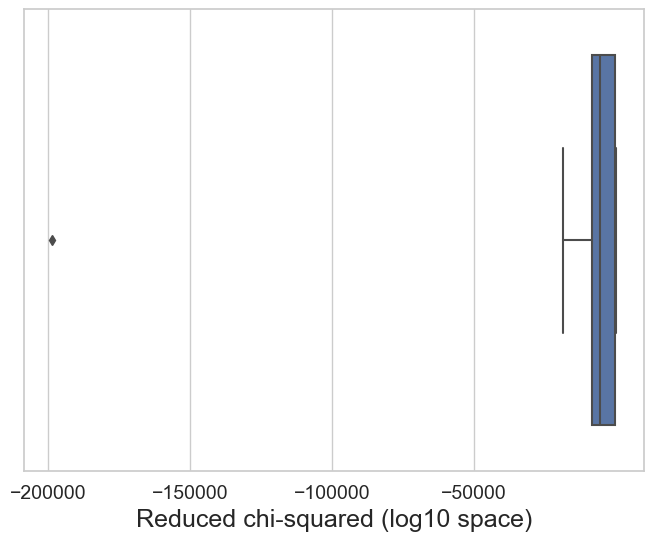

In [7]:
# Make plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=df['Reduced chi-squared (log10 space)'], ax=ax)
# Customize plot
ax.set_xticks(range(-200000, 0, 50000))
# Display figure
plt.show()

This corresponds to the final row of our dataframe (`index=99`).

In [8]:
df.tail()

,Class,Wavelength (microns),Slope,Unc_slope,Intercept,Unc_intercept,Reduced chi-squared (log10 space),Correlation coefficient (linear space),Correlation coefficient (log10 space),Std. Dev. of Model Variance
95,All,0.250002,1.630436,0.009861,-13.685973,0.010334,-16251.317989,0.090796,0.524678,1.002673
96,All,1.000008,0.596907,0.006827,-9.904205,0.007099,-11638.138915,0.667610,0.298847,1.985282
97,All,0.400003,1.161575,0.009316,-11.618105,0.009717,-17869.732545,0.109263,0.414432,1.360949
98,All,0.700006,0.739158,0.007685,-10.250403,0.007997,-14088.912098,0.373893,0.326713,1.789473
99,All,0.050000,8.579801,0.078281,-47.486629,0.083609,-198663.860003,0.068419,0.418470,1.343842


Due to the eccentric nature of this observation, we choose to drop the row from the following analyses.

In [9]:
# Drop rows with extreme outliers
df.drop(index=99, inplace=True)

# Data Analysis

To begin our analyses, we first visualize reduced chi-squared (in `log10` space) as a function of wavelength.

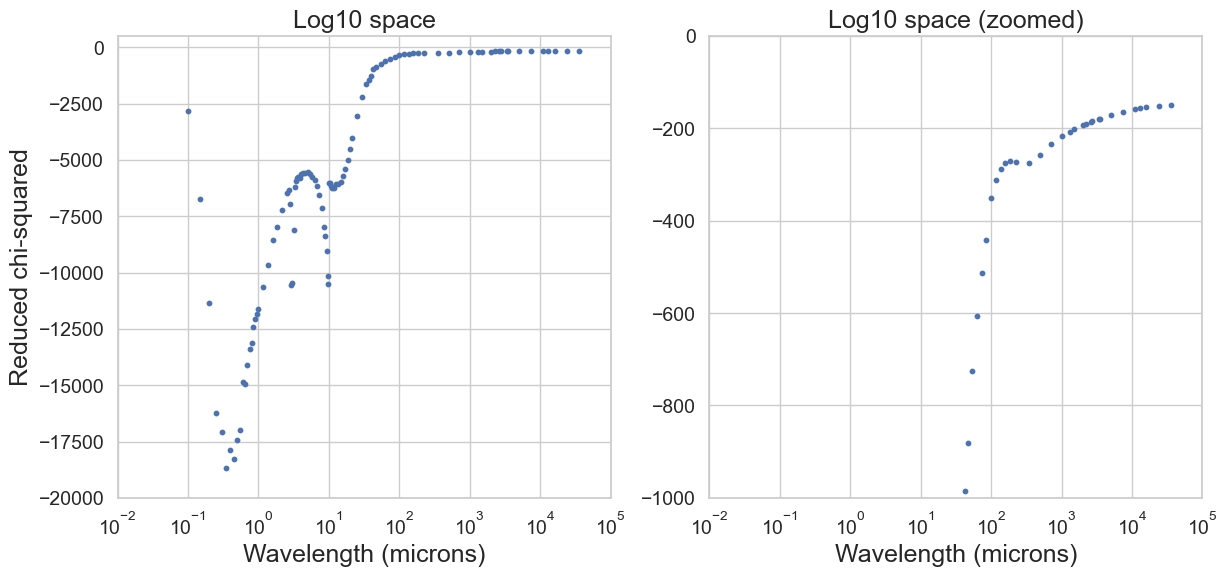

In [10]:
# Create 2-figure plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# Plot reduced chi-squared against wavelength
ax[0].scatter(df['Wavelength (microns)'], df['Reduced chi-squared (log10 space)'], s=10, marker='o')
# Customize plot
ax[0].set_title('Log10 space')
ax[0].set_xlabel('Wavelength (microns)')
ax[0].set_ylabel('Reduced chi-squared')
ax[0].set_xscale('log')
ax[0].set_xlim([1e-2, 1e5])
ax[0].set_ylim([-20000, 500])
# Zoom in on the region of interest
ax[1].scatter(df['Wavelength (microns)'], df['Reduced chi-squared (log10 space)'], s=10, marker='o')
# Repeat customizations
ax[1].set_title('Log10 space (zoomed)')
ax[1].set_xlabel('Wavelength (microns)')
ax[1].set_xscale('log')
ax[1].set_xlim([1e-2, 1e5])
ax[1].set_ylim([-1000, 0])
# Save figure
plt.savefig(f'Figures/chi_sq.eps', format='eps', dpi=1200)
plt.savefig(f'../src/images/chi_sq.jpg', format='jpg')
# Display figure
plt.show()

Next, we visualize correlation coefficient, in both linear and `log10` space, as a function of wavelength.

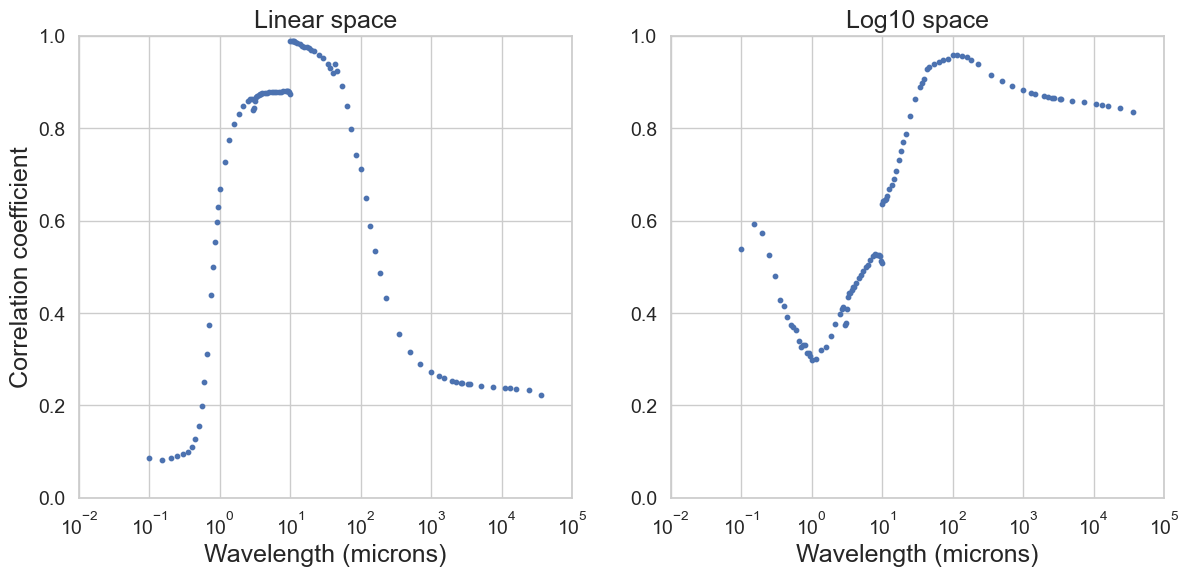

In [11]:
# Create 2-figure plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# Plot correlation coefficient in linear space against wavelength
ax[0].scatter(df['Wavelength (microns)'], df['Correlation coefficient (linear space)'], s=10, marker='o')
# Customize plot
ax[0].set_title('Linear space')
ax[0].set_xlabel('Wavelength (microns)')
ax[0].set_ylabel('Correlation coefficient')
ax[0].set_xscale('log')
ax[0].set_xlim([1e-2, 1e5])
ax[0].set_ylim([0, 1])
# Plot correlation coefficient in log10 space against wavelength
ax[1].scatter(df['Wavelength (microns)'], df['Correlation coefficient (log10 space)'], s=10, marker='o')
# Repeat customizations
ax[1].set_title('Log10 space')
ax[1].set_xlabel('Wavelength (microns)')
ax[1].set_xscale('log')
ax[1].set_xlim([1e-2, 1e5])
ax[1].set_ylim([0, 1])
# Save figure
plt.savefig(f'Figures/corr_coef.eps', format='eps', dpi=1200)
plt.savefig(f'../src/images/corr_coef.jpg', format='jpg')
# Display figure
plt.show()

Finally (and most significantly), visualize the 1 $\sigma$ model variances against wavelength. We'll also examine the underlying distribution via its histogram.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


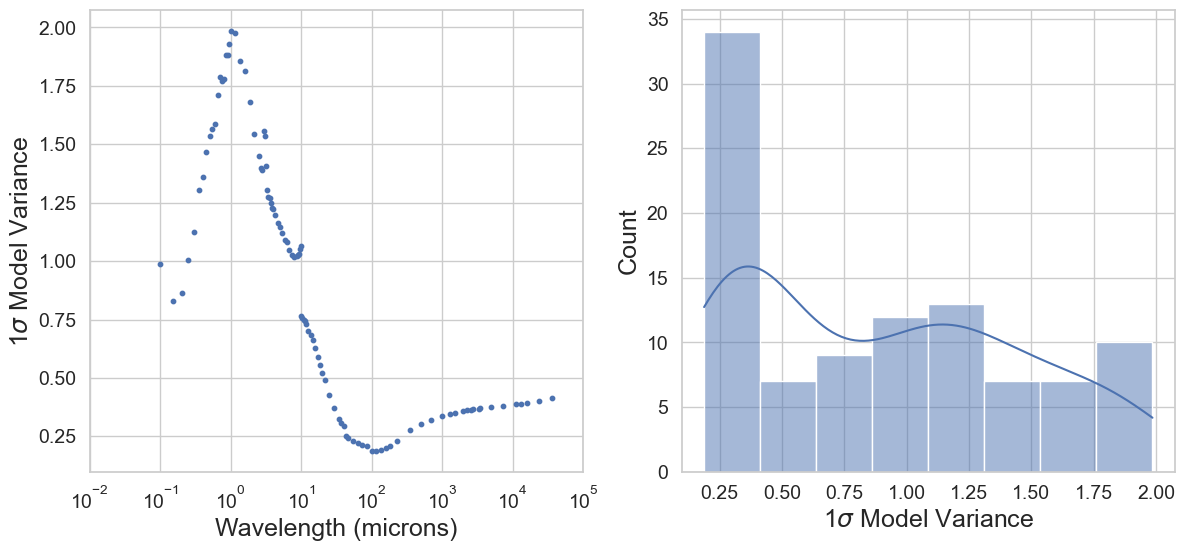

In [12]:
# Create 2-figure plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# Plot 1 sigma model variance against wavelength
ax[0].scatter(df['Wavelength (microns)'], df['Std. Dev. of Model Variance'], s=10, marker='o')
# Customize plot
ax[0].set_xlabel('Wavelength (microns)')
ax[0].set_ylabel('1$\sigma$ Model Variance')
ax[0].set_xscale('log')
ax[0].set_xlim([1e-2, 1e5])
# Plot histogram of 1 sigma model variances
sns.histplot(data=df['Std. Dev. of Model Variance'], kde=True, ax=ax[1])
# Customize plot
ax[1].set_xlabel('1$\sigma$ Model Variance')
# Save figure
plt.savefig(f'Figures/model_var.eps', format='eps', dpi=1200)
plt.savefig(f'../src/images/model_var.jpg', format='jpg')
# Display figure
plt.show()

Using the model variances as our guiding metric, it remains to set an upper-threshold value, such that we obtain a corresponding range of wavelength values as our optimal wavelength range.

In [13]:
# Filter wavelengths based on model variance threshold
threshold = 0.333
df[df['Std. Dev. of Model Variance'] <= threshold]['Wavelength (microns)']

16    700.005737
17    500.004100
18    350.002869
19    226.001857
20    184.801511
21    158.501296
22    135.901112
23    116.600955
24    100.000820
25     85.770702
26     73.570602
27     63.100518
28     54.120444
29     46.420380
30     42.990353
31     39.810326
32     36.870302
33     34.150280
Name: Wavelength (microns), dtype: float64

Indeed, a threshold of `0.333` yields a wavelength range of $\left[10^1,\;10^2\right]$ microns.

# Conclusion

We conclude that our optimal wavelength range exists between $10^1$ and $10^2$ microns.